In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import sys
import os
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR'], '..'))

In [24]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import shap
from xgboost import XGBClassifier


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import src.features.build_features as FeaturesManager
import src.features.select_features as FeaturesSelector
import src.features.detect_outliers as OutliersManager
import src.visualization.visualize as VizManager
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



In [7]:
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
data_df = FeaturesManager.build_features(seasons_year, season_type, with_player_stats=True, with_strength_stats=True)

features_to_keep = FeaturesManager.GetFeaturesToKeep()

feature_names, target_name = features_to_keep[0:-1], features_to_keep[-1]
feature_names = np.array(feature_names)

df_features = data_df[feature_names]
df_targets = data_df[target_name]

X = df_features
y = df_targets

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [16]:
numerical_columns = [
    'Period seconds', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 
    'Speed From Previous Event', 'Change in Shot Angle', 
    'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season',
    'Elapsed time since Power Play', 'Last event elapsed time', 'Last event st_X', 'Last event st_Y', 
    'Last event distance', 'Last event angle']

nominal_columns = ['Shot Type', 'Strength', 'Shooter Side', 'Shooter Ice Position']
ordinal_columns = ['Period', 'Num players With', 'Num players Against', 'Is Empty', 'Rebound']

In [22]:
# SHAP Analysis to find the best features

# median
fill_nan = ColumnTransformer(transformers = [
    ('cat', SimpleImputer(strategy ='most_frequent'), nominal_columns + ordinal_columns),
    ('num', SimpleImputer(strategy ='median'), numerical_columns),
], remainder ='passthrough')

# one-hot      
one_hot = ColumnTransformer(transformers = [
    ('enc', OneHotEncoder(sparse = False), list(range(len(nominal_columns)))),
], remainder ='passthrough')

xbg = XGBClassifier(random_state=RANDOM_SEED)
steps = [('fill_nan', fill_nan), ('one_hot', one_hot),  ("xbg", xbg)]
pipeline = Pipeline(steps=steps).fit(X, y)
    
# explain the model's predictions using SHAP
explainer = shap.Explainer(pipeline)
shap_values = explainer(X)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('fill_nan',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Shot Type', 'Strength',
                                                   'Shooter Side',
                                                   'Shooter Ice Position',
                                                   'Period', 'Num players With',
                                                   'Num players Against',
                                                   'Is Empty', 'Rebound']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Period seconds', 'st_X',
                                                   'st_Y', 'Shot distance',
                                                   'Shot an...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

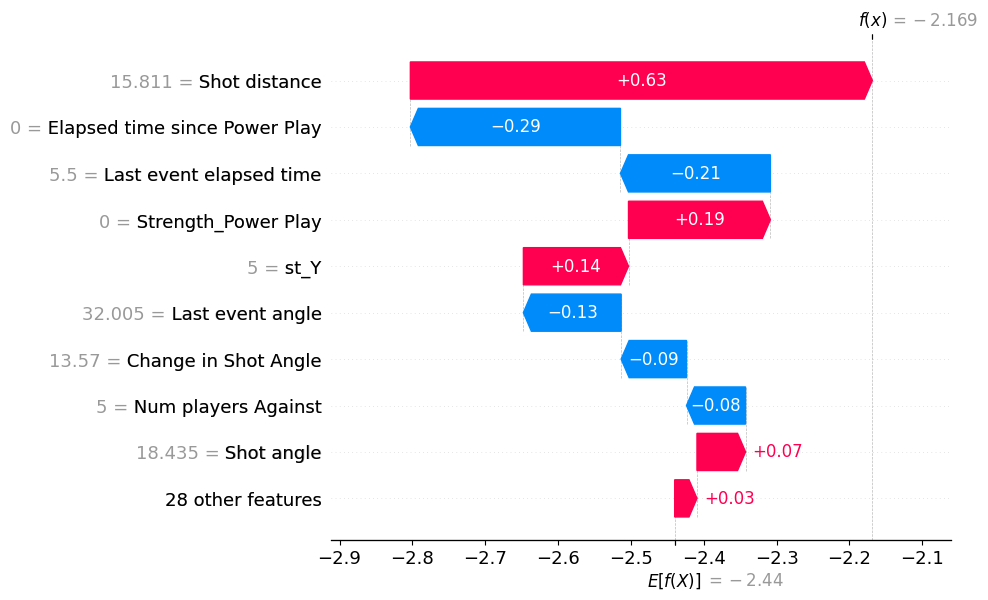

In [11]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [23]:
from comet_ml import API
import pickle

api = API()
workspace_name = "ift6758-a22-g08"


# Download the Adaboost / Anova
api.download_registry_model(workspace_name, "adaboost-anova", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Adaboost_Anova.pkl")
with open(pkl_filename, 'rb') as file:
    clf_adaboost_anova = pickle.load(file)


# Download the Random Forest
api.download_registry_model(workspace_name, "randomforest", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "randomforest.pkl")
with open(pkl_filename, 'rb') as file:
    clf_random_forest = pickle.load(file) 
    
# Download the Knn / Linear SVC
api.download_registry_model(workspace_name, "knn-lasso", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "KNN_Lasso.pkl")
with open(pkl_filename, 'rb') as file:
    clf_knn = pickle.load(file)

    
# Download the Easy Ensemble / PCA
api.download_registry_model(workspace_name, "easyensemble-pca", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "EasyEnsemble_PCA.pkl")
with open(pkl_filename, 'rb') as file:
    clf_easyensemble_pca = pickle.load(file)


# Download the Random Forest / Variance Threshold
api.download_registry_model(workspace_name, "forest-binning-shap-var", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Forest_Binning_SHAP_Var.pkl")
with open(pkl_filename, 'rb') as file:
    clf_forest_var = pickle.load(file)

COMET INFO: Downloading registry model 'adaboost-anova', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'randomforest', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'knn-lasso', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'easyensemble-pca', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'forest-binning-shap-var', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unz

In [83]:
import src.models.HP_AdaBoost as HP_AdaBoost
import src.models.HP_RandomForest as HP_RandomForest
import src.models.HP_KNN as HP_KNN
import src.models.HP_EasyEnsemble as HP_EasyEnsemble

X_train_adaboost, X_valid_adaboost, y_train_adaboost, y_valid_adaboost = HP_AdaBoost.GetTrainingData()
# print(classification_report(y_valid_adaboost, clf_adaboost_anova.predict(X_valid_adaboost)))

X_train_forest, X_valid_forest, y_train_forest, y_valid_forest, _, _, _ = HP_RandomForest.GetTrainingData()
# print(classification_report(y_valid_forest, clf_random_forest.predict(X_valid_forest)))

X_train_knn, X_valid_knn, y_train_knn, y_valid_knn = HP_KNN.GetTrainingData()
# print(classification_report(y_valid_knn, clf_knn.predict(X_valid_knn)))

X_train_easy, X_valid_easy, y_train_easy, y_valid_easy = HP_EasyEnsemble.GetTrainingData()
# print(classification_report(y_valid_easy, clf_knn.predict(X_valid_easy)))

X_train_forest_shap, X_valid_forest_shap, y_train_forest_shap, y_valid_forest_shap, _, _, _ = HP_RandomForest.GetTrainingData(shap=True)
# print(classification_report(y_valid_forest_shap, clf_forest_var.predict(X_valid_forest_shap)))

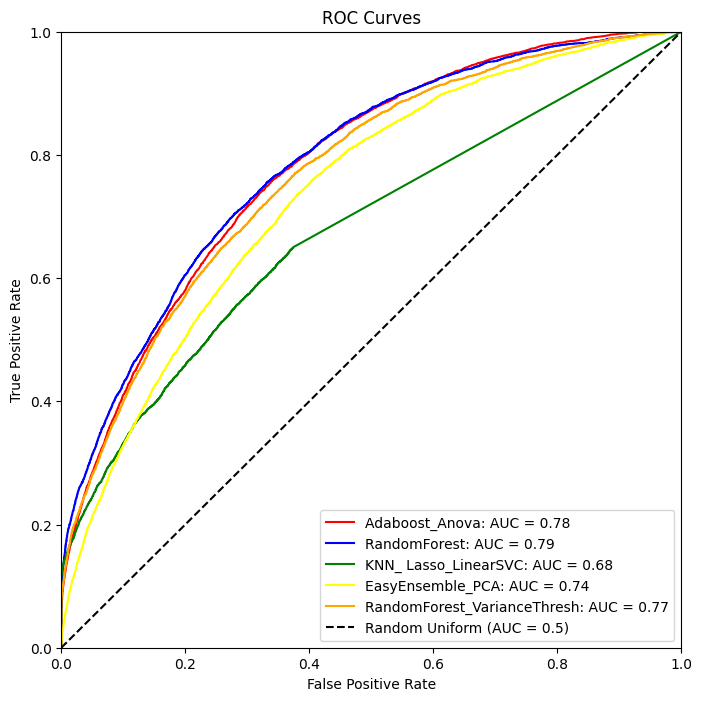

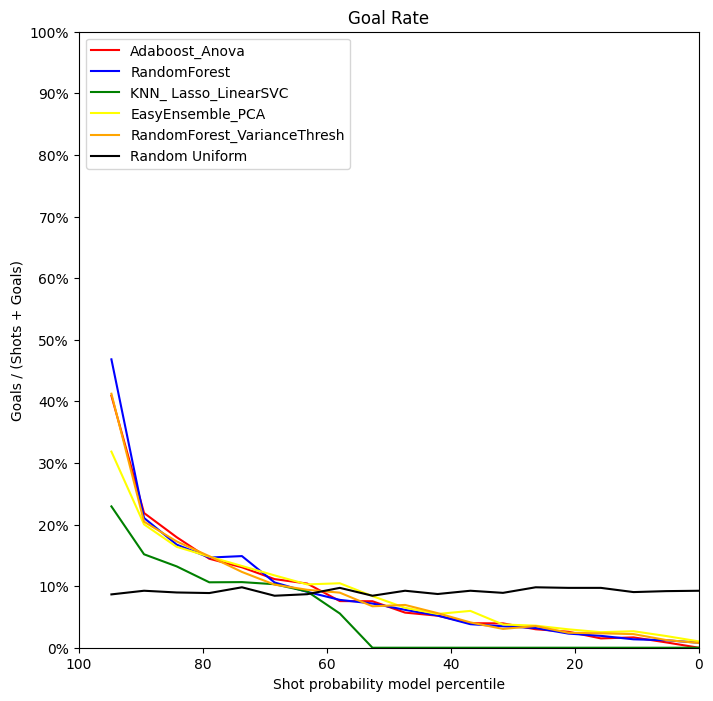

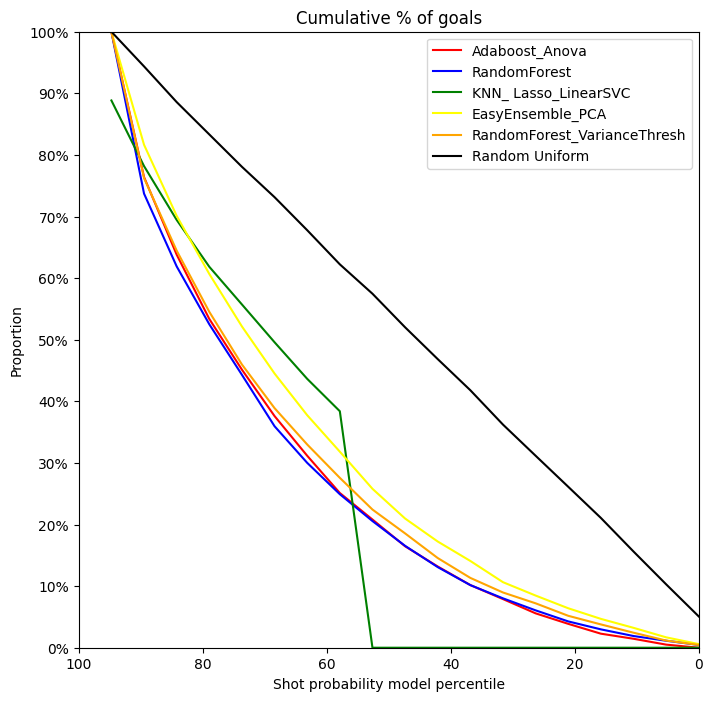

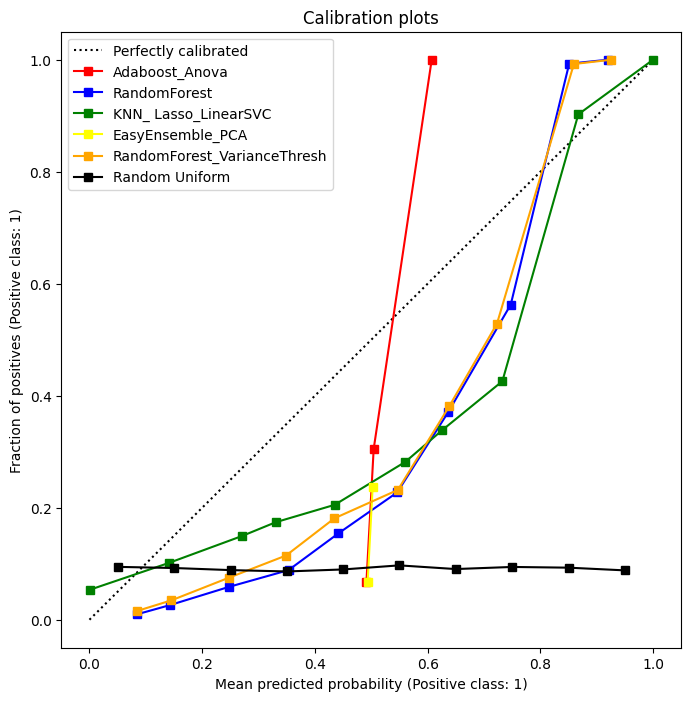

In [66]:
classifiers = [(clf_adaboost_anova, 'Adaboost_Anova', X_valid_adaboost, y_valid_adaboost),
               (clf_random_forest, 'RandomForest', X_valid_forest, y_valid_forest),
               (clf_knn, 'KNN_ Lasso_LinearSVC', X_valid_knn, y_valid_knn),
               (clf_easyensemble_pca, 'EasyEnsemble_PCA', X_valid_easy, y_valid_easy),
               (clf_forest_var, 'RandomForest_VarianceThresh', X_valid_forest_shap, y_valid_forest_shap)]

VizManager.plot_all_figures(classifiers, add_random=True, plot_name='Best_Models')

In [87]:
from sklearn.calibration import CalibratedClassifierCV

index = X_valid_adaboost['Shooter Ice Position'] != 'G'
X_valid_adaboost = X_valid_adaboost[index]
y_valid_adaboost = y_valid_adaboost[index]
calibrated_clf_adaboost = CalibratedClassifierCV(base_estimator=clf_adaboost_anova, cv=3)
calibrated_clf_adaboost.fit(X_valid_adaboost, y_valid_adaboost)

index = X_valid_forest['Shooter Ice Position'] != 'G'
X_valid_forest = X_valid_forest[index]
y_valid_forest = y_valid_forest[index]
calibrated_clf_forest = CalibratedClassifierCV(base_estimator=clf_random_forest, cv=3)
calibrated_clf_forest.fit(X_valid_forest, y_valid_forest)

index = X_valid_knn['Shooter Ice Position'] != 'G'
X_valid_knn = X_valid_knn[index]
y_valid_knn = y_valid_knn[index]
calibrated_clf_knn = CalibratedClassifierCV(base_estimator=clf_knn, cv=3)
calibrated_clf_knn.fit(X_valid_knn, y_valid_knn)

# index = X_valid_easy['Shooter Ice Position'] != 'G'
# X_valid_easy = X_valid_easy[index]
# y_valid_easy = y_valid_easy[index]

# calibrated_clf_easy_pca = CalibratedClassifierCV(base_estimator=clf_easyensemble_pca, cv=3)
# calibrated_clf_easy_pca.fit(X_valid_easy, y_valid_easy)


# index = X_valid_forest_shap['Angle Bins'] != 'd0'
# X_valid_forest_shap = X_valid_forest_shap[index]
# y_valid_forest_shap = y_valid_forest_shap[index]
# calibrated_clf_forest_shap = CalibratedClassifierCV(base_estimator=clf_forest_var, cv=3)
# calibrated_clf_forest_shap.fit(X_valid_forest_shap, y_valid_forest_shap)


CalibratedClassifierCV(base_estimator=Pipeline(steps=[('fill_nan',
                                                       ColumnTransformer(remainder='passthrough',
                                                                         transformers=[('cat',
                                                                                        SimpleImputer(strategy='most_frequent'),
                                                                                        ['Shot '
                                                                                         'Type',
                                                                                         'Strength',
                                                                                         'Shooter '
                                                                                         'Side',
                                                                                         'Shooter '
                                                                                         'Ice '
                                                                                         'Position',
                                                                                         'Period',
                                                                                         'Num '
                                                                                         'players '
                                                                                         'With',
                                                                                         'Num '
                                                                                         'players '
                                                                                         'Against',
                                                                                         'Is '
                                                                                         'Empty',
                                                                                         'Rebound']),
                                                                                       ('num',
                                                                                        SimpleImputer(strategy='median...
                                                                                         'Power '
                                                                                         'Play',
                                                                                         'Last '
                                                                                         'event '
                                                                                         'elapsed '
                                                                                         'time',
                                                                                         'Last '
                                                                                         'event '
                                                                                         'st_X',
                                                                                         'Last '
                                                                                         'event '
                                                                                         'st_Y',
                                                                                         'Last '
                                                                                         'event '
                                                                                         'distance',
                                                                                         'Last '
                                                          

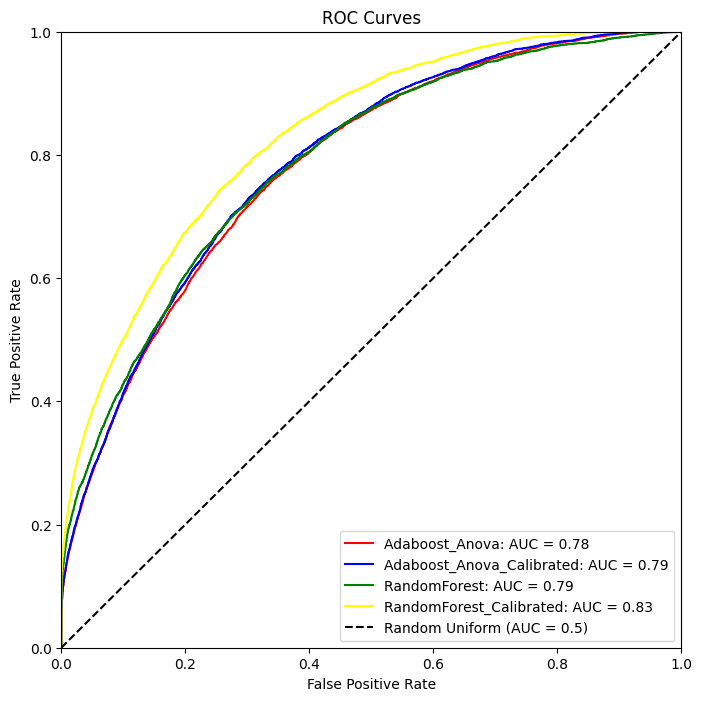

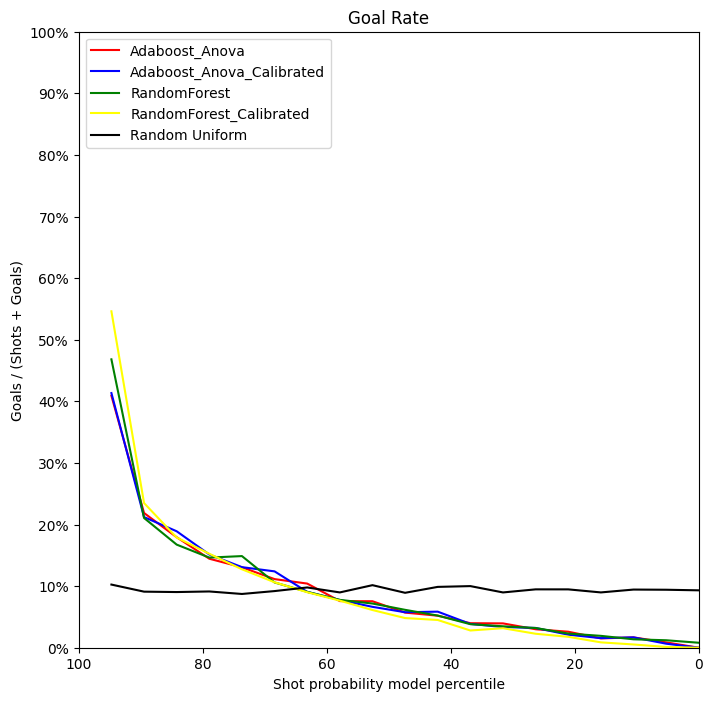

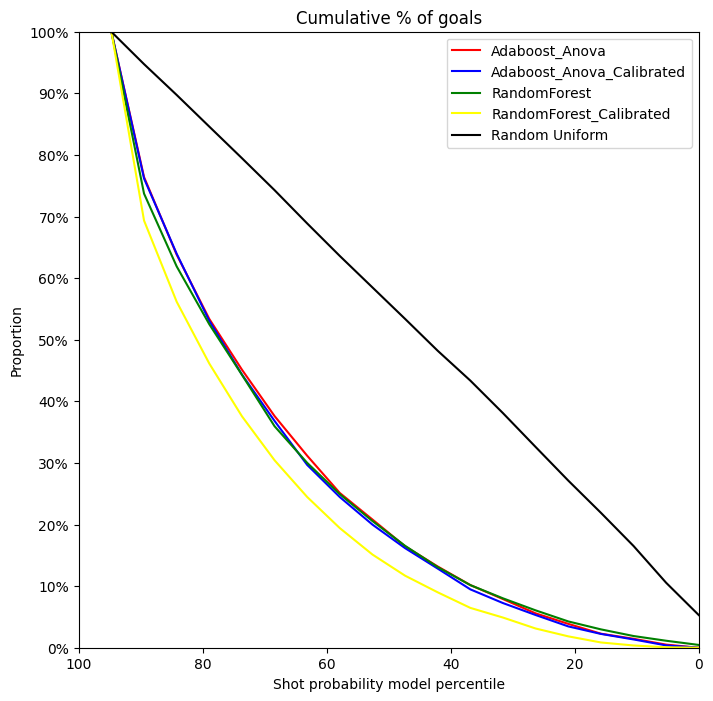

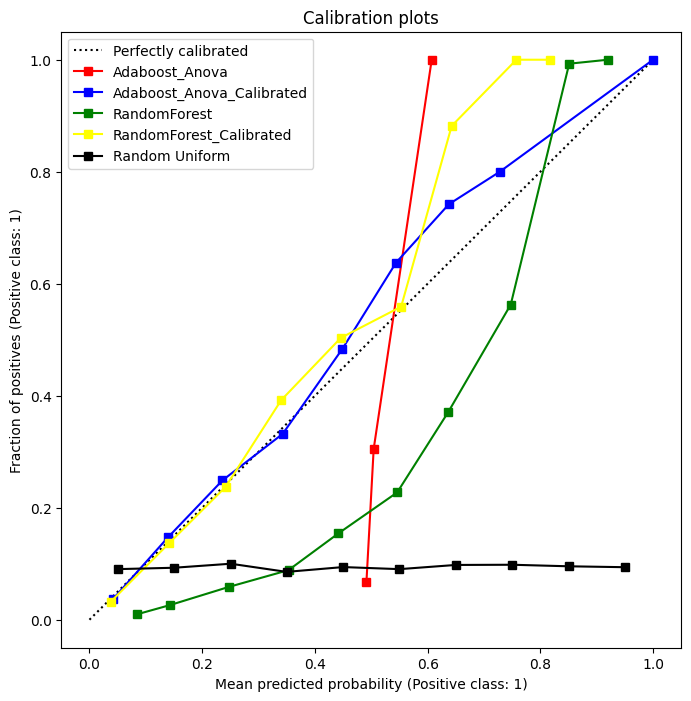

In [89]:
# classifiers = [(calibrated_clf_adaboost, 'Adaboost_Anova_Calibrated', X_valid_adaboost, y_valid_adaboost),
#                (calibrated_clf_forest, 'RandomForest_Calibrated', X_valid_forest, y_valid_forest),
#                (calibrated_clf_knn, 'KNN_Lasso_LinearSVC_Calibrated', X_valid_knn, y_valid_knn),
#                (calibrated_clf_easy_pca, 'EasyEnsemble_PCA_Calibrated', X_valid_easy, y_valid_easy),
#                (calibrated_clf_forest_shap, 'RandomForest_VarianceThresh_Calibrated', X_valid_forest_shap, y_valid_forest_shap)]


classifiers = [(clf_adaboost_anova, 'Adaboost_Anova', X_valid_adaboost, y_valid_adaboost),
               (calibrated_clf_adaboost, 'Adaboost_Anova_Calibrated', X_valid_adaboost, y_valid_adaboost),
               (clf_random_forest, 'RandomForest', X_valid_forest, y_valid_forest),
               (calibrated_clf_forest, 'RandomForest_Calibrated', X_valid_forest, y_valid_forest)]

VizManager.plot_all_figures(classifiers, add_random=True, plot_name='Calibrated_VS_NonCalibrated')